# Introduction of Bayesian model estimation
The aim of the introduction is to simply demonstrate how to use Bayesian model estimation to estimate the parameters of a model.

The example we use in this introduction is to find the relationship between the level of assistance and the level of self-efficacy for experimental participants. More precisely, we want to know how level of assistance affects the level of self-efficacy. We will use the Bayesian model estimation to estimate relationship. 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
# import os

def plot_model(x, y):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(x, y)
    ax.set_xlabel("Assistance")
    ax.set_ylabel("Normalised self-efficacy")
    ax.set_title("Assistance vs Normalised self-efficacy")
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.grid(True)
    plt.show()

# Participant 
In this example, we simply assume that the relationship between the level of assistance and the level of self-efficacy follows a specific function which maps the level of assistance to the level of self-efficacy. Therefore, this function is our **model** of the relationship. 

For example, if we assume the relationship is linear, then the model is:

$$
\begin{align}
\text{self-efficacy} = \text{intercept} + \text{slope} \times \text{assistance}
\end{align}
$$

with two parameters: intercept and slope.

Assuming the slope = 0.9 and intercept = 0.2, the relationship between the level of assistance and the level of self-efficacy is shown in the following figure.

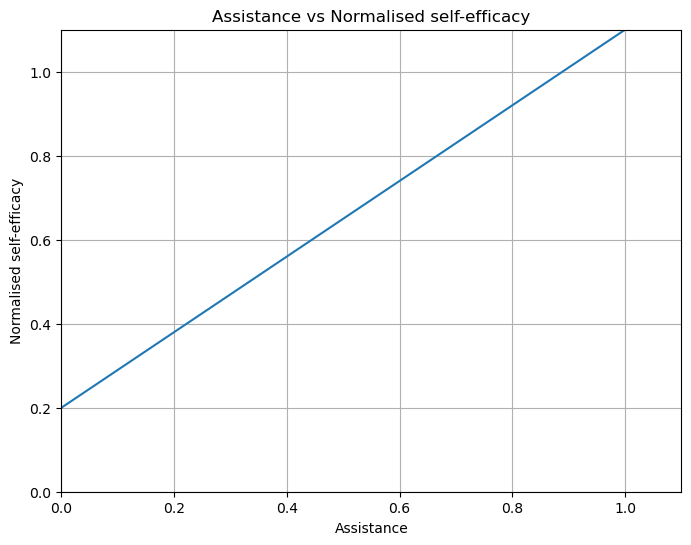

In [21]:
def f_linear(x, slope, intercept):
    return slope * x + intercept

# Plot model
slope = 0.9
intercept = 0.2
x = np.linspace(0, 1, 100)
y = f_linear(x, slope, intercept)
plot_model(x, y)

## A slightly more complicated model
In the above example, we assume the relationship between the level of assistance and the level of self-efficacy is linear. However, in reality, the relationship is more complicated. For example, the relationship may be quadratic, cubic, or even more complicated. 

A more realistic scenario would be the relationship is an _inverse U shape_. In this case, the model we can use a function which can flexibly fit the inverse U shape relationship. For example, we can use a modified version of the function of beta distribution to model the relationship.

It's mathematical form is:

$$
\begin{align}
\text{self-efficacy} &= f_{\text{BetaNorm}}(\alpha, \beta, x) \\
&= \frac{x^{\alpha-1}(1-x)^{\beta-1}}{\left(\frac{\alpha-1}{\alpha+\beta-2}\right)^{\alpha-1}\left(1-\frac{\alpha-1}{\alpha+\beta-2}\right)^{\beta-1}}
\end{align}
$$

where $x$ is the level of assistance, $\alpha$ and $\beta$ are the parameters of the function.


In [17]:
def f_BetaNorm(alpha, beta, x):
    # without scipy.stats.beta
    x_max = (alpha - 1) / (alpha + beta - 2)
    y = x**(alpha-1) * (1 - x)**(beta-1)
    y_max = x_max**(alpha-1) * (1 - x_max)**(beta-1)
    y_normalized = y / y_max
    return y_normalized

For example, the following figure shows two models from two sets of function parameters:
1. alpha = 7, beta = 7
2. alpha = 3, beta = 6


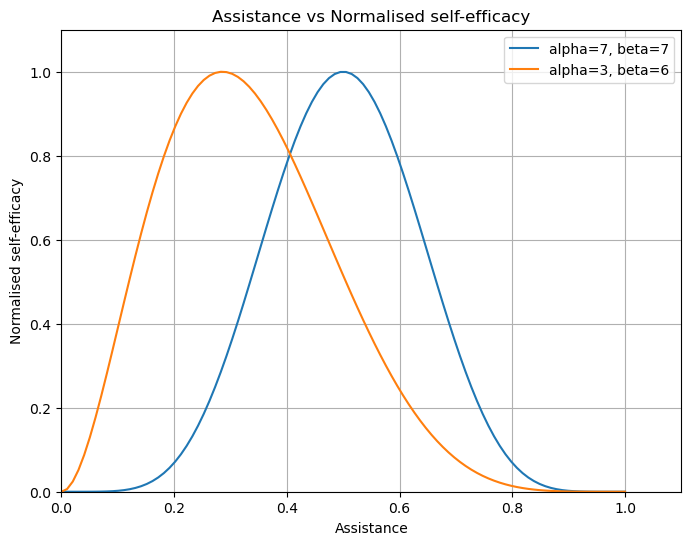

In [19]:
# Set the parameters
alpha1, beta1 = 7, 7
alpha2, beta2 = 3, 6

# Generate the x values
x = np.linspace(0, 1, 100)

# Generate the y values for each set of parameters
y1 = f_BetaNorm(alpha1, beta1, x)
y2 = f_BetaNorm(alpha2, beta2, x)

# Plot the two models
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x, y1, label='alpha=7, beta=7')
ax.plot(x, y2, label='alpha=3, beta=6')
ax.set_xlabel("Assistance")
ax.set_ylabel("Normalised self-efficacy")
ax.set_title("Assistance vs Normalised self-efficacy")
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.grid(True)
ax.legend()
plt.show()


Therefore, to find the correct (most probable) model of the relationship between the level of assistance and the level of self-efficacy is equivalent to find the correct parameters of the function. 

# Dummy participant and dummy data

Before move to the Bayesian model estimation, we first create a dummy participant and dummy data.
Assuming, we have a dummy participant, the internal model of the participants follows the $f_{\text{BetaNorm}}$ function we described above with parameters $\alpha = 8$ and $\beta = 2$.

So the internal model should be like this:

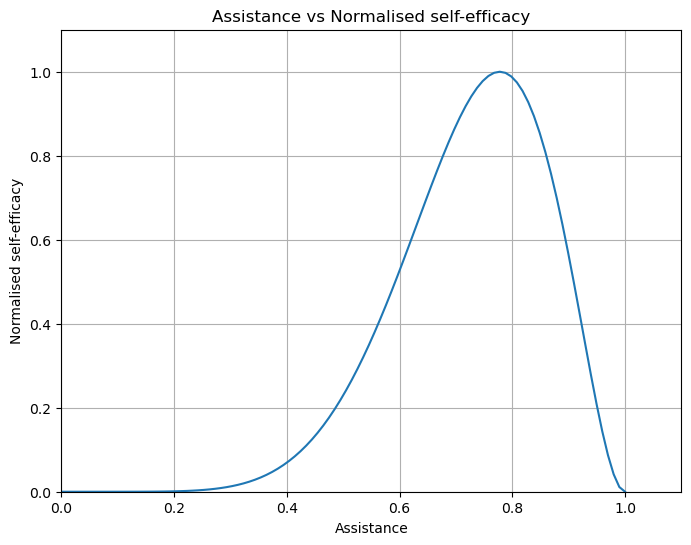

In [25]:
# Plot model
alpha_true = 8
beta_true = 3
x = np.linspace(0, 1, 100)
y = f_BetaNorm(alpha_true, beta_true, x)
plot_model(x, y)


Considering the there are some noise of the participants' internal model, we can generate the dummy data by adding some noise to the output of the internal model. 

We can model the noise distribution as a normal distribution with mean = 0 and standard deviation = 0.1.

Now we consider we collect 100 samples from the dummy participant. The following figure shows the dummy data.

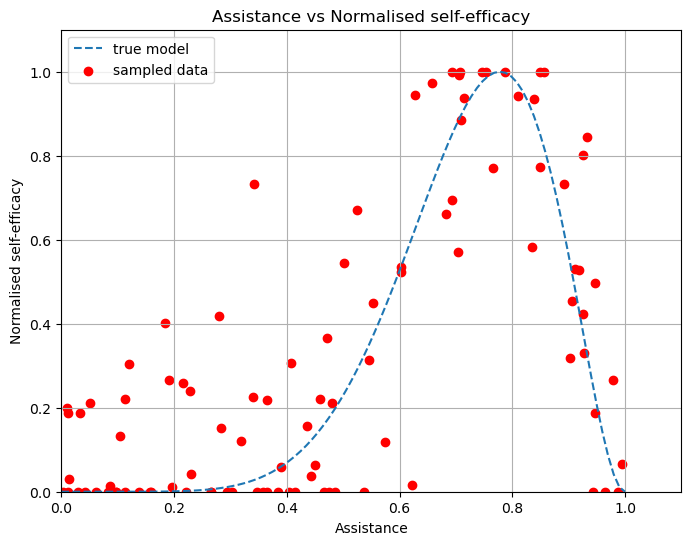

In [39]:
n = 100
sigma_true = 0.2

# generate data
x_sampled = np.random.uniform(0, 1, n)
y_sampled = f_BetaNorm(alpha_true, beta_true, x_sampled) + np.random.normal(0, sigma_true, n)
# make y in [0, 1]
y_sampled = np.clip(y_sampled, 0, 1)


# plot model and data
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x, y, '--', label='true model')
ax.scatter(x_sampled, y_sampled, color='red', label='sampled data')
ax.set_xlabel("Assistance")
ax.set_ylabel("Normalised self-efficacy")
ax.set_title("Assistance vs Normalised self-efficacy")
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(True)
plt.show()

# Bayesian model estimation

Therefore, to find the true model, we need to make our best guess of the parameters of the model. So far, we have three parameters needed to be estimated: $\alpha$, $\beta$, and $\sigma$.

In Bayesian inference, we don't only estimate the parameters, but also estimate the uncertainty (distribution) of the parameters. Therefore, we need to specify the prior distribution of the parameters.

Assuming we have no knowledge of $\alpha$ and $\beta$, we can assume they follow a uniform distribution between 0 and 10. We also give a prior distribution to $\sigma$, assuming it follows a Gamma distribution.

The likelihood function discernible how the data is generated from the model. In this example, we assume the data is generated following the $f_{\text{BetaNorm}}$ function with parameters $\alpha$, $\beta$, and $\sigma$.

From here, we can build the model with priors

In [40]:
# Define the model
model = pm.Model()

with model:
    # prior
    alpha = pm.Uniform("alpha", lower=0, upper=10)
    beta = pm.Uniform("beta", lower=0, upper=10)
    sigma = pm.Gamma("sigma", alpha=1, beta=1)

    # Model function
    mu = f_BetaNorm(alpha, beta, x_sampled)

    # draw 1000 prior samples
    idata = pm.sample(tune=200, chains=1, cores=1)
    
alpha_estimated = np.mean(idata.posterior['alpha'].values)
beta_estimated = np.mean(idata.posterior['beta'].values)
sigma_estimated = np.mean(idata.posterior['sigma'].values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, sigma]


Sampling 1 chain for 200 tune and 1_000 draw iterations (200 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


The following figure shows the real and prior predicted model. They are quite different. The prior predicted model is not a good model of the data (of course we haven't considered the data yet).

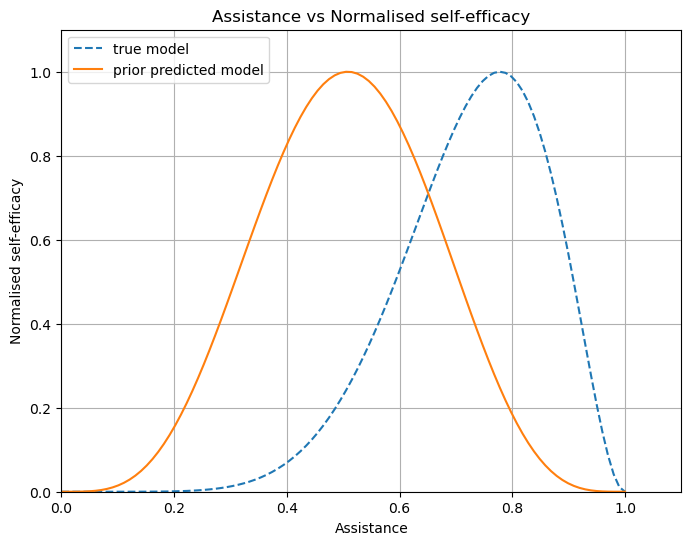

In [41]:
# plot the prior predicted model and true model
y_estimated = f_BetaNorm(alpha_estimated, beta_estimated, x)
y_true = f_BetaNorm(alpha_true, beta_true, x)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x, y_true, '--', label='true model')
ax.plot(x, y_estimated, label='Prior predicted model')
ax.set_xlabel("Assistance")
ax.set_ylabel("Normalised self-efficacy")
ax.set_title("Assistance vs Normalised self-efficacy")
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(True)
plt.show()

We can also visualize the joint prior distribution of the parameters $\alpha$ and $\beta$ as follows:

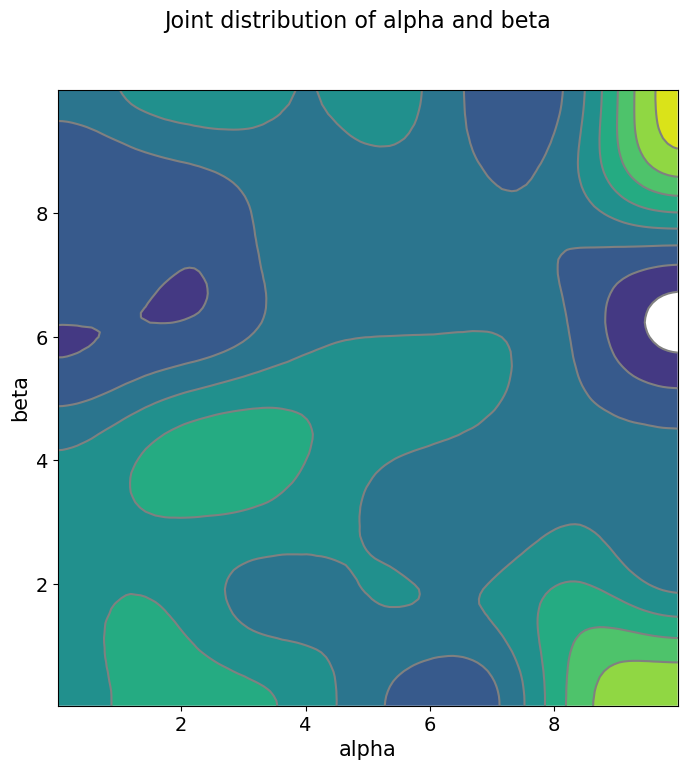

In [61]:
# plot joint distribution of alpha and beta in 2d heatmap
az.plot_pair(
    idata,
    var_names=["alpha", "beta"],
    kind="kde",
    figsize=[8, 8],
    divergences=True,
    textsize=14,
    colorbar=True,
)

# add title to heatmap
plt.suptitle("Joint distribution of alpha and beta", fontsize=16);


You can see the joint prior distribution of $\alpha$ and $\beta$ is a uniform distribution: There is no preference of any value of $\alpha$ and $\beta$.


We can also visualize the marginal prior distribution of the parameters $\alpha$ and $\beta$ as follows:

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

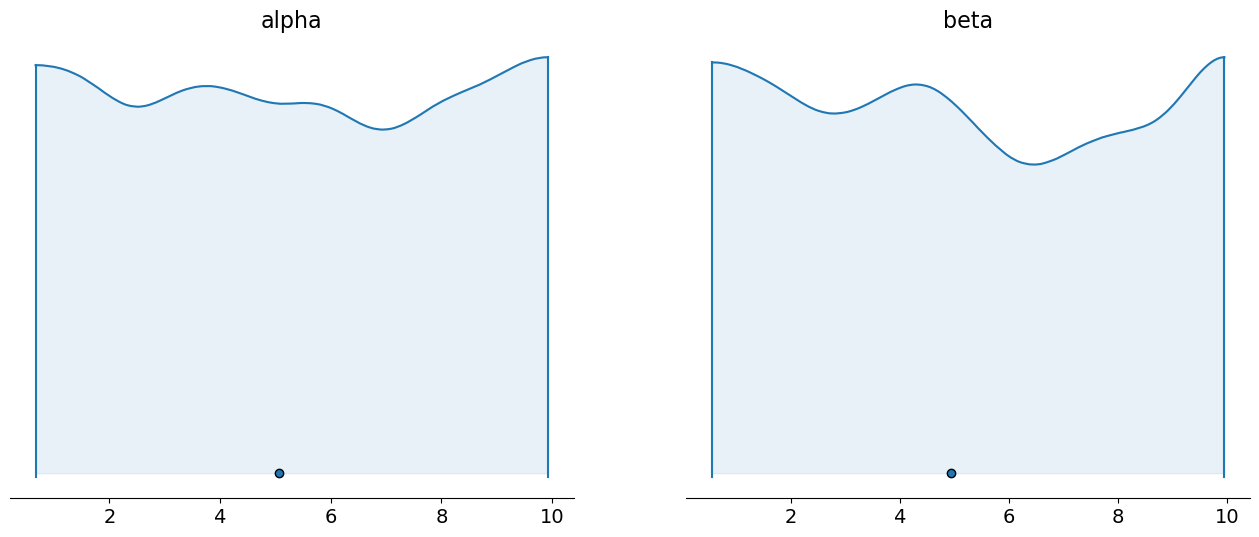

In [68]:
# Plot marginal distribution of alpha and beta without smapling trace
# az.plot_posterior(idata, var_names=["alpha", "beta"], figsize=(16, 6), textsize=14)
az.plot_density(idata, var_names=["alpha", "beta"], shade=0.1, figsize=(16, 6))

The same as the joint prior distribution, the marginal prior distribution of $\alpha$ and $\beta$ is also a uniform distribution without any preference of any value of $\alpha$ and $\beta$.

## Update the model with new data to get posterior distribution of parameters

The advantage of Bayesian inference is that we can update our beliefs of the model parameters based on the data we have observed.

Let's first try to update the model with the first 10 data points.

In [69]:
# update model with 10 data points
n_sample = 10
x_sampled_ = x_sampled[:n_sample]
y_sampled_ = y_sampled[:n_sample]

model = pm.Model()
with model:
    # uniform prior
    alpha = pm.Uniform("alpha", lower=0, upper=10)
    beta = pm.Uniform("beta", lower=0, upper=10)
    sigma = pm.Gamma("sigma", alpha=1, beta=1)
        
    # Model function
    mu = f_BetaNorm(alpha, beta, x_sampled_)
        
    # likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_sampled_)

    # draw 1000 posterior samples
    idata = pm.sample(tune=200, chains=1, cores=1)

alpha_estimated = np.mean(idata.posterior['alpha'].values)
beta_estimated = np.mean(idata.posterior['beta'].values)
sigma_estimated = np.mean(idata.posterior['sigma'].values)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, sigma]


Sampling 1 chain for 200 tune and 1_000 draw iterations (200 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Here is our updated model

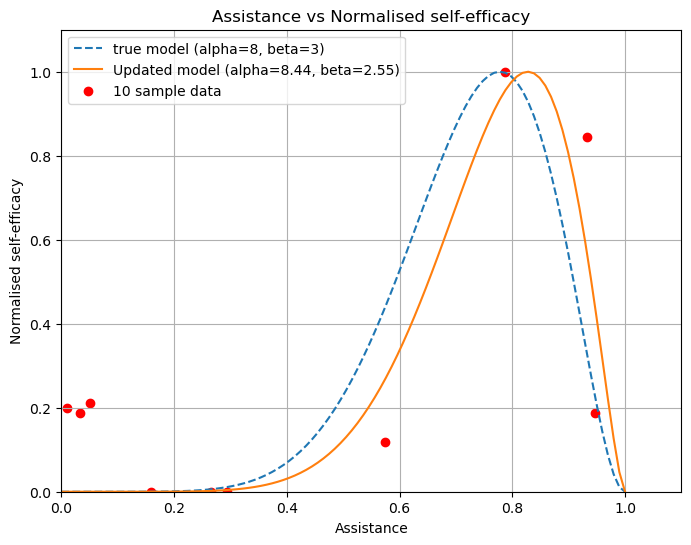

In [75]:
y_estimated = f_BetaNorm(alpha_estimated, beta_estimated, x)
y_true = f_BetaNorm(alpha_true, beta_true, x)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x, y_true, '--', label=f'true model (alpha={alpha_true}, beta={beta_true})')
ax.plot(x, y_estimated, label=f'Updated model (alpha={alpha_estimated:.2f}, beta={beta_estimated:.2f})')
ax.scatter(x_sampled_, y_sampled_, color='red', label=f'{n_sample} sample data')
ax.set_xlabel("Assistance")
ax.set_ylabel("Normalised self-efficacy")
ax.set_title("Assistance vs Normalised self-efficacy")
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(True)
plt.show()

We can examine the posterior distribution of the parameters $\alpha$ and $\beta$ and their joint distribution as follows:

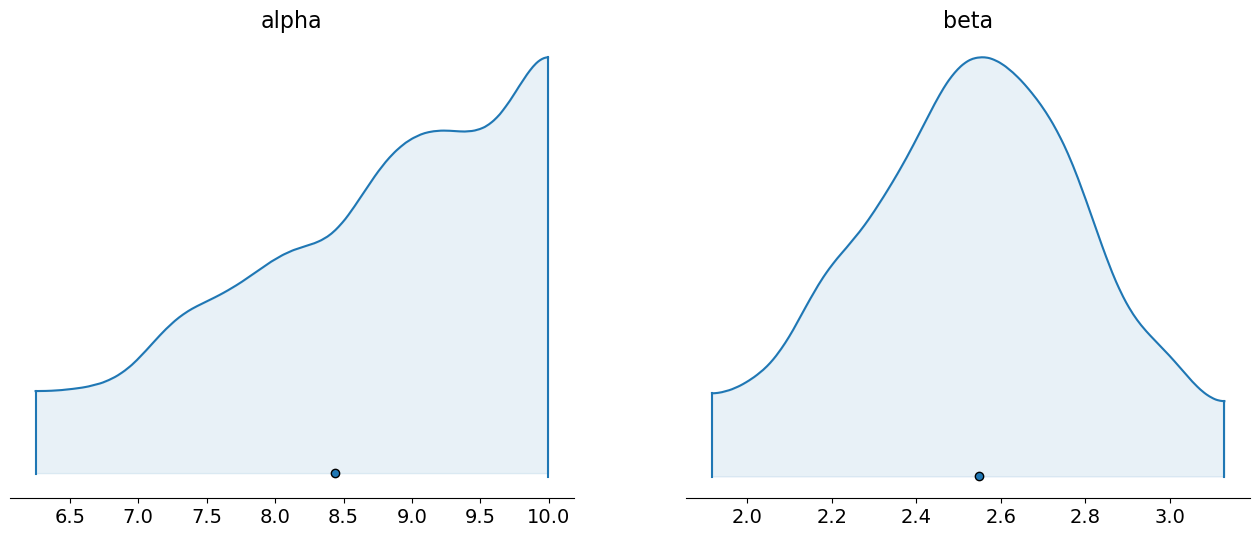

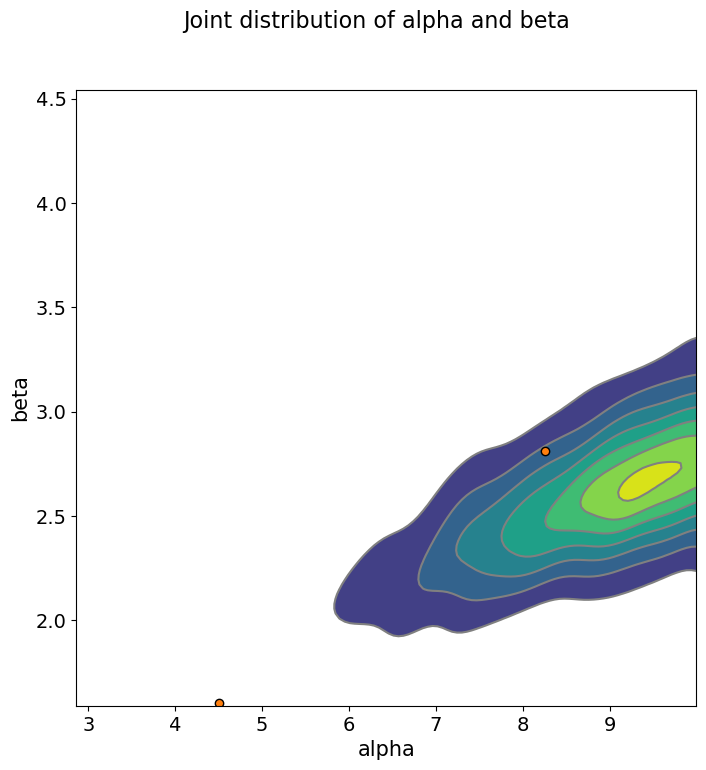

In [78]:
az.plot_density(idata, var_names=["alpha", "beta"], shade=0.1, figsize=(16, 6));



az.plot_pair(
    idata,
    var_names=["alpha", "beta"],
    kind="kde",
    figsize=[8, 8],
    divergences=True,
    textsize=14,
    colorbar=True,
)

# add title to heatmap
plt.suptitle("Joint distribution of alpha and beta", fontsize=16);

We can see that the estimated parameters are pretty close to the true parameters just by 10 samples. 

### Update the model with all data

We can also update the model with all data. Here is the updated model

In [79]:
# update model with 10 data points
n_sample = 100
x_sampled_ = x_sampled[:n_sample]
y_sampled_ = y_sampled[:n_sample]

model = pm.Model()
with model:
    # uniform prior
    alpha = pm.Uniform("alpha", lower=0, upper=10)
    beta = pm.Uniform("beta", lower=0, upper=10)
    sigma = pm.Gamma("sigma", alpha=1, beta=1)
        
    # Model function
    mu = f_BetaNorm(alpha, beta, x_sampled_)
        
    # likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_sampled_)

    # draw 1000 posterior samples
    idata = pm.sample(tune=200, chains=1, cores=1)

alpha_estimated = np.mean(idata.posterior['alpha'].values)
beta_estimated = np.mean(idata.posterior['beta'].values)
sigma_estimated = np.mean(idata.posterior['sigma'].values)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, sigma]


Sampling 1 chain for 200 tune and 1_000 draw iterations (200 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


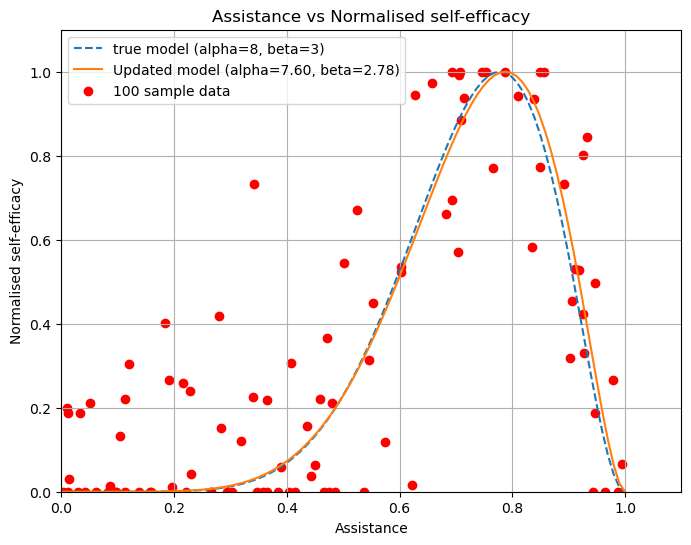

In [80]:
y_estimated = f_BetaNorm(alpha_estimated, beta_estimated, x)
y_true = f_BetaNorm(alpha_true, beta_true, x)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x, y_true, '--', label=f'true model (alpha={alpha_true}, beta={beta_true})')
ax.plot(x, y_estimated, label=f'Updated model (alpha={alpha_estimated:.2f}, beta={beta_estimated:.2f})')
ax.scatter(x_sampled_, y_sampled_, color='red', label=f'{n_sample} sample data')
ax.set_xlabel("Assistance")
ax.set_ylabel("Normalised self-efficacy")
ax.set_title("Assistance vs Normalised self-efficacy")
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(True)
plt.show()

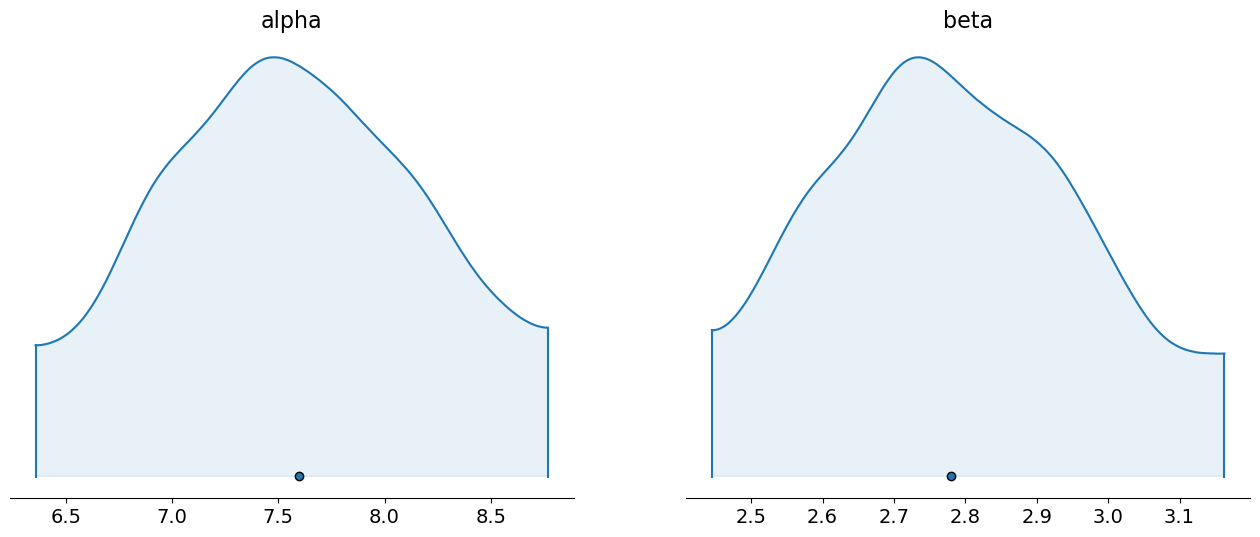

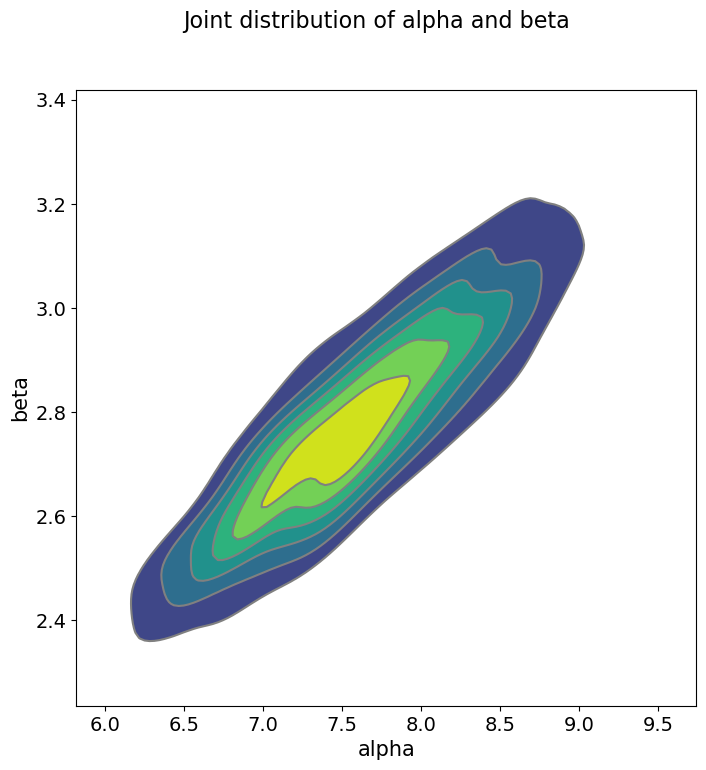

In [81]:
az.plot_density(idata, var_names=["alpha", "beta"], shade=0.1, figsize=(16, 6));

az.plot_pair(
    idata,
    var_names=["alpha", "beta"],
    kind="kde",
    figsize=[8, 8],
    divergences=True,
    textsize=14,
    colorbar=True,
)

# add title to heatmap
plt.suptitle("Joint distribution of alpha and beta", fontsize=16);

We can see the posterior distribution of the parameters $\alpha$ and $\beta$ and their joint distribution become more narrow and certain.

%matplotlib qt
